# Ground Extraction Using Differential Morphological Profiles

This notebook will walk users through the process of extracting ground returns from point cloud data according to the work of Mongus [1]. The algorithm consists of three primary steps:

1. Initialization
2. Decomposition of grid and feature mapping
3. Point filtering

[1] D. Mongus, N. Lukac, and B. Zalik, “Ground and building extraction from LiDAR data based on differential morphological profiles and locally fitted surfaces,” ISPRS J. Photogramm. Remote Sens., vol. 93, no. January, pp. 145–156, 2014.

Now proceed with our imports. There are seven packages that are required, two of which are only needed for visualization in the notebook. The five that are truly required for data processing are `numpy`, `pandas`, `pdal`, and `scipy`.

In [1]:
%matplotlib inline

from scipy import ndimage, signal, spatial
from scipy.ndimage import morphology

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdal
import seaborn as sns

plt.set_cmap('plasma');

So that we can walk through the algorithm step-by-step, we start by executing a reader-only pipeline to read our point cloud input. In this case, we are using the `samp11` file from the ISPRS ground filtering test data suite.

In [2]:
%%time
json=u'''{
    "pipeline":[
        "/data/bare_earth_eval/isprs/converted/laz/samp11-utm.laz"
    ]
}'''
p = pdal.Pipeline(json)
p.validate()
count = p.execute()

CPU times: user 30 ms, sys: 10 ms, total: 40 ms
Wall time: 87.6 ms


Let's read just the XYZ coordinates of the data into a `pandas` DataFrame.

In [3]:
%%time
df3D = pd.DataFrame(p.arrays[0], columns=['X','Y','Z'])

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 26.3 ms


The algorithm requires the user to set four parameters. `S` indicates the depth of the scale space decomposition. `k` and `n` are used to define a per point threshold for determining ground/non-ground in the estimated surface. And `b` defines a tolerance for determining if a point is sufficiently close to the estimated surface to be labeled ground. For the ISPRS data, the authors have provided reasonable values for each of the parameters. The following should work well for `samp11`.

In [4]:
S = 30
k = 0.2
n = 0.3
b = 0.2

The target resolution of the estimated surface is set automatically as the inverse of the estimated density $D_L$

$$R_g=\frac{1.0}{D_L}$$

The density is defined as

$$D_L=\frac{N}{area}$$

where $N$ is the number of points (should really be last/only returns) and $area$ is estimated here by the bounding box. There can and should be more sophisticated methods for estimating density for actual data.

In [5]:
%%time
density = count / (p.arrays[0]['Y'].ptp() * p.arrays[0]['X'].ptp())
hres = 1. / density

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 49.7 ms


In [6]:
print "Point cloud density estimated as", density, "pts/m^2. Processing at", hres, "m resolution."

Point cloud density estimated as 0.937765534471 pts/m^2. Processing at 1.06636463299 m resolution.


## Initialization

Initilize the process by selecting points with lowest elevation at the target resolution.

We begin by computing bin edges ranging between XY min and max, spaced at a fixed resolution.

In [7]:
%%time
xi = np.ogrid[p.arrays[0]['X'].min():p.arrays[0]['X'].max():hres]
yi = np.ogrid[p.arrays[0]['Y'].min():p.arrays[0]['Y'].max():hres]

CPU times: user 90 ms, sys: 10 ms, total: 100 ms
Wall time: 94.3 ms


We use our bin edges to group each point by it's corresponding XY bin.

In [8]:
%%time
bins = df3D.groupby([np.digitize(p.arrays[0]['X'], xi), np.digitize(p.arrays[0]['Y'], yi)])

CPU times: user 50 ms, sys: 0 ns, total: 50 ms
Wall time: 48.8 ms


For each bin, find the minimum elevation, and record the XYZ coordinates at that point.

In [9]:
%%time
zmins = bins.Z.min()
cz = np.empty((yi.size, xi.size))
cz.fill(np.nan)
for name, val in zmins.iteritems():
    cz[name[1]-1, name[0]-1] = val

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 21.6 ms


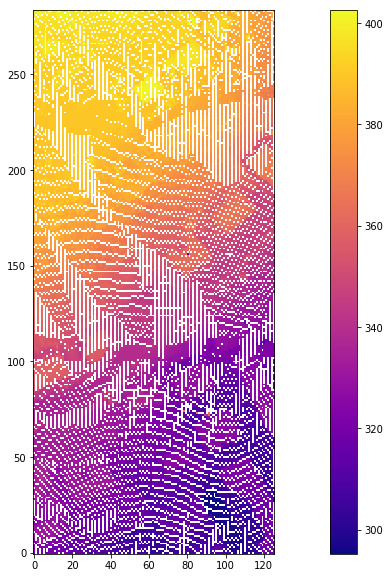

In [10]:
plt.figure(figsize=(20,10)); plt.imshow(cz, origin='lower'); plt.colorbar();

There is no Python package that I am aware of that will perform IDW to interpolate nans. IDW being defined as

$$g[p_n^*]=\frac{\sum_{p_n \in W^{p_n^*}}g[p_n]d_{p_n}^{-r}}{\sum_{p_n \in W^{p_n^*}}d_{p_n}^{-r}}$$

where $d_{p_n}$ is the Euclidean distance between $p_n^*$ and $p_n$ and $r=2$ defines the smoothness of the interpolation.

The following function should do the trick.

In [11]:
def idw(data):
    # Find indices of the ground returns, i.e., anything that is not a nan, and create a KD-tree.
    # We will search this tree when looking for nearest neighbors to perform the interpolation.
    valid = np.argwhere(~np.isnan(data))
    tree = spatial.cKDTree(valid)
    
    # Now find indices of the non-ground returns, as indicated by nan values. We will interpolate
    # at these locations.
    nans = np.argwhere(np.isnan(data))    
    for row in nans:
        d, idx = tree.query(row, k=12)
        d = np.power(d, -2)
        v = data[valid[idx, 0], valid[idx, 1]]
        data[row[0], row[1]] = np.inner(v, d)/np.sum(d)
        
    return data

For any remaining undefined cells, estimate via IDW.

In [12]:
%%time
cz = idw(cz)

CPU times: user 540 ms, sys: 80 ms, total: 620 ms
Wall time: 550 ms


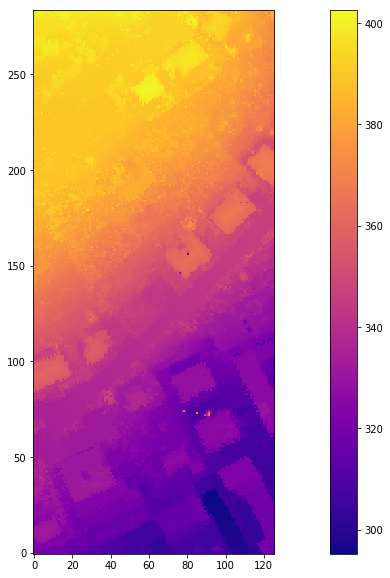

In [13]:
plt.figure(figsize=(20,10)); plt.imshow(cz, origin='lower'); plt.colorbar();

Replace those points that are more than 1.0m below the estimated surface (as determined by morphological opening/closing).

Begin by opening the control elevations using a diamond structuring element with radius 11.

In [14]:
%%time
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 11).astype(int)
opened = morphology.grey_opening(cz, structure=struct)

CPU times: user 60 ms, sys: 110 ms, total: 170 ms
Wall time: 59.4 ms


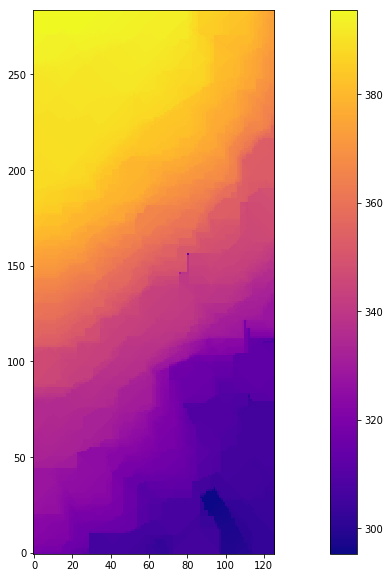

In [15]:
plt.figure(figsize=(20,10)); plt.imshow(opened, origin='lower'); plt.colorbar();

Close the control elevations using a diamond structuring element with radius 9.

In [16]:
%%time
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 9).astype(int)
closed = morphology.grey_closing(opened, structure=struct)

CPU times: user 40 ms, sys: 70 ms, total: 110 ms
Wall time: 37.2 ms


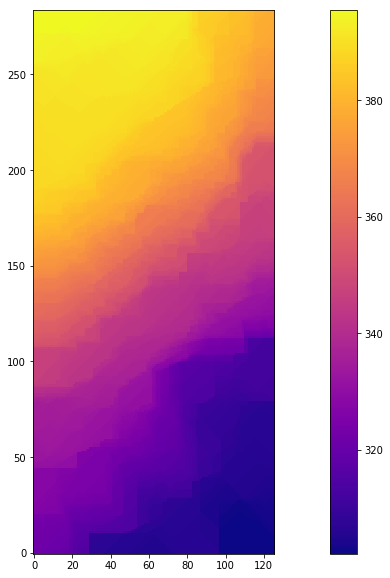

In [17]:
plt.figure(figsize=(20,10)); plt.imshow(closed, origin='lower'); plt.colorbar();

Record the locations where there appear to be low outliers, and replace with the morphologically altered surface.

In [18]:
%%time
lowx, lowy = np.where((closed - cz) >= 1.0)
cz[lowx, lowy] = closed[lowx, lowy]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 566 µs


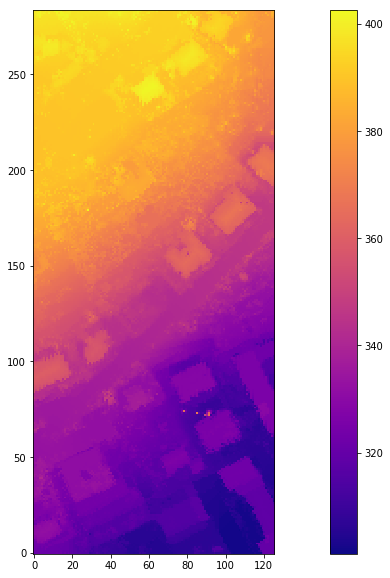

In [19]:
plt.figure(figsize=(20,10)); plt.imshow(cz, origin='lower'); plt.colorbar();

## Decomposition of grid and feature mapping

Convolve $g$ with a Gaussian kernel $G$ large enough to remove all contained non-ground features.

$$g^{\downarrow}=g*G$$

$g^{\downarrow}$ contains low-frequency terrain undulations, providing a rough approximation of the ground surface.

In [20]:
%%time
stdev = 14
G = np.outer(signal.gaussian(113,stdev), signal.gaussian(113,stdev))
low = signal.fftconvolve(np.pad(cz,2*stdev,'edge'), G, mode='same')[2*stdev:-2*stdev,2*stdev:-2*stdev]/1000.

CPU times: user 0 ns, sys: 60 ms, total: 60 ms
Wall time: 16.7 ms


The high frequency information is the residual of $g$ and $g^{\downarrow}$, and contains the non-ground features.

$$g^{\uparrow}=g-g^{\downarrow}$$

Further processing is performed only on $g^{\uparrow}$.

In [21]:
%%time
high = cz - low

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 150 µs


The initialized surface, as well as the low and high pass frequency bands are shown below.

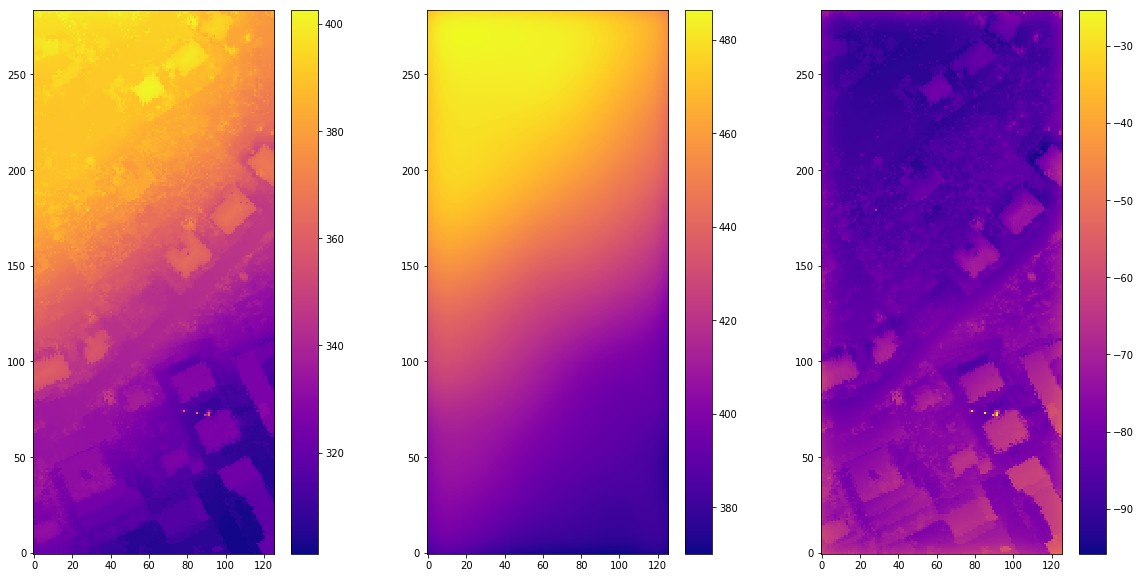

In [22]:
plt.figure(figsize=(20, 10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(low, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(high, origin='lower'); plt.colorbar();

Multiscale decomposition achieved by using a granulometry of morphological openings $\gamma_{w_{s_{i}}}(g^{\uparrow})$

In [23]:
%%time
erosions = []
granulometry = []
erosions.append(morphology.grey_erosion(high, size=3))
for scale in xrange(1, S):
    erosions.append(morphology.grey_erosion(erosions[scale-1], size=3))
for scale in xrange(1, S+1):
    granulometry.append(morphology.grey_dilation(erosions[scale-1], size=2*scale+1))

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 50.2 ms


A top-hat scale-space, known as DMPs

$$\Delta(g^{\uparrow})=\{\gamma_{w_{s_{i-1}}}(g^{\uparrow})-\gamma_{w_{s_{i}}}(g^{\uparrow})\}$$

where $i\in[1,I]$ and $I=cardinality(s)-1$.

In [24]:
%%time
out = []
for i in xrange(1, len(granulometry)):
    out.append(granulometry[i-1]-granulometry[i])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.27 ms


- $g^{\prime}$ registers the largest response from $\Delta(g^{\uparrow})$ at each point $p$

$$g^{\prime}[p]=\bigvee_{i\in[1,I]}\Delta(g^{\uparrow})[p][i]$$

- $g^*$ describes the smallest scale at which the largest response is registered

$$g^*[p]=\bigwedge_{i\in[1,I]}s_i \big| \Delta(g^{\uparrow})[p][i]=g^{\prime}[p]$$

- $g^+$ is the sum of all responses up to and including the largest response

$$g^+[p]=\sum_{i \le g^*[p]}\Delta(g^{\uparrow})[p][i]$$

In [25]:
%%time
gprime = np.maximum.reduce(out)
xs, ys = out[0].shape
gstar = np.zeros((xs,ys))
gplus = np.zeros((xs,ys))
for ii in xrange(0,xs):
    for jj in xrange(0,ys):
        for kk in xrange(0,len(out)):
            if out[kk][ii,jj] < gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
            if out[kk][ii,jj] == gprime[ii,jj]:
                gplus[ii,jj] += out[kk][ii,jj]
                gstar[ii,jj] = kk
                break

CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 553 ms


$g^{\prime}$, $g^*$, and $g^+$ are plotted below.

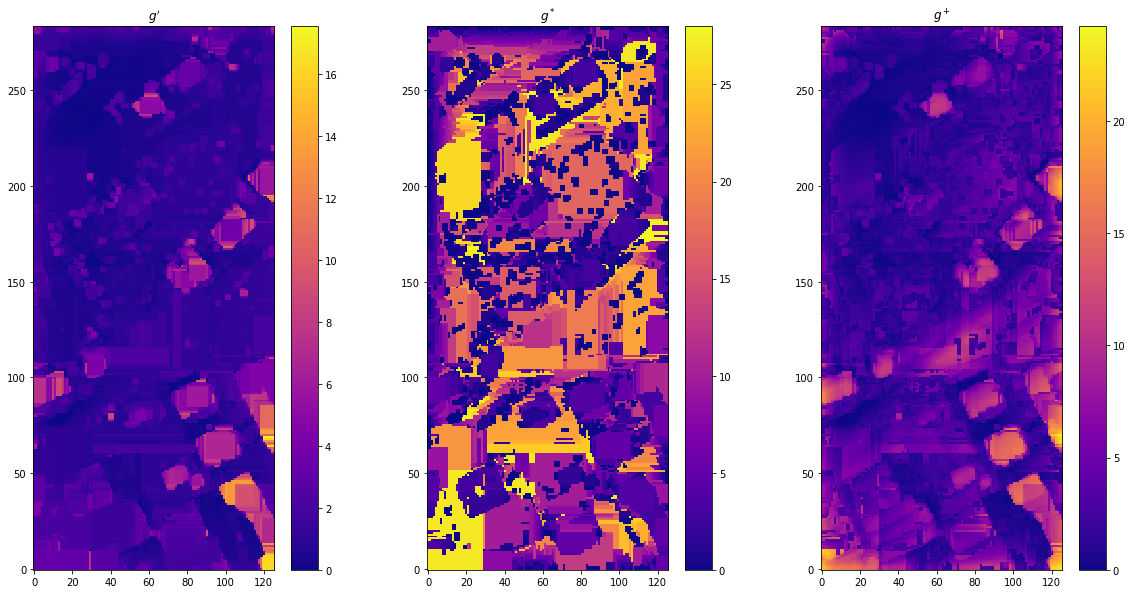

In [26]:
plt.figure(figsize=(20, 10));
plt.subplot(1,3,1); plt.imshow(gprime, origin='lower'); plt.colorbar(); plt.title('$g^{\prime}$')
plt.subplot(1,3,2); plt.imshow(gstar, origin='lower'); plt.colorbar(); plt.title('$g^*$')
plt.subplot(1,3,3); plt.imshow(gplus, origin='lower'); plt.colorbar(); plt.title('$g^+$')

## Point filtering

In [27]:
%%time
T = k * gstar + n
Sg = gprime < T

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 415 µs


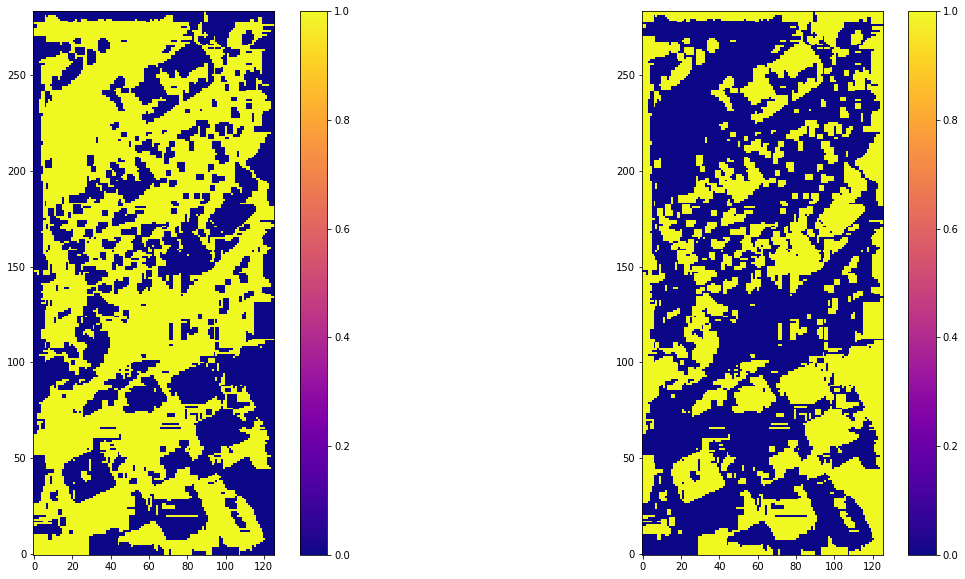

In [28]:
plt.figure(figsize=(20, 10));
plt.subplot(1,2,1); plt.imshow(Sg, origin='lower'); plt.colorbar();
plt.subplot(1,2,2); plt.imshow(gprime >= T, origin='lower'); plt.colorbar();

In [29]:
%%time
F = cz.copy()
F[np.where(Sg==0)] = np.nan

CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 904 µs


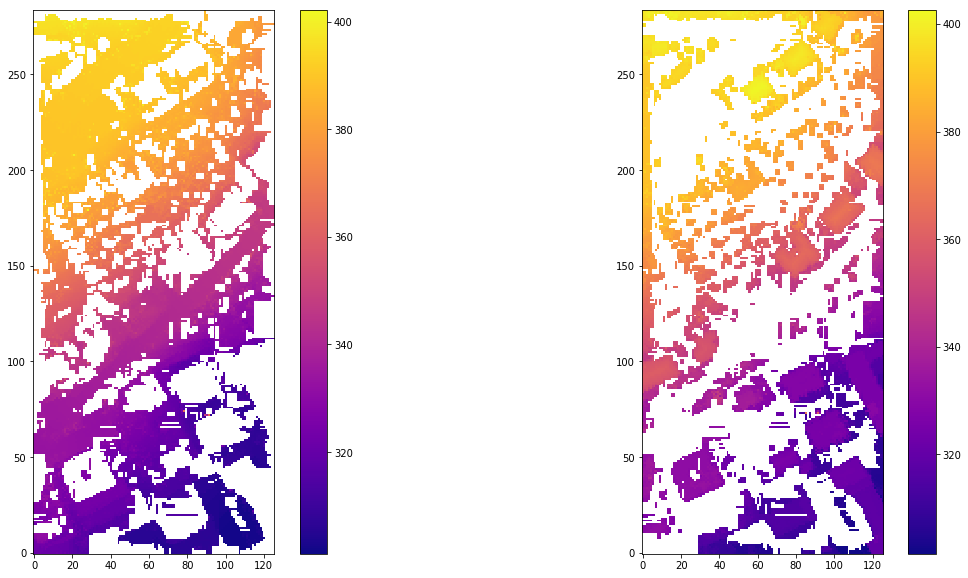

In [30]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.imshow(F, origin='lower'); plt.colorbar();
nonGround = cz.copy()
nonGround[np.where(Sg==1)] = np.nan
plt.subplot(1,2,2); plt.imshow(nonGround, origin='lower'); plt.colorbar();

In [31]:
%%time
G = idw(F)

CPU times: user 770 ms, sys: 70 ms, total: 840 ms
Wall time: 774 ms


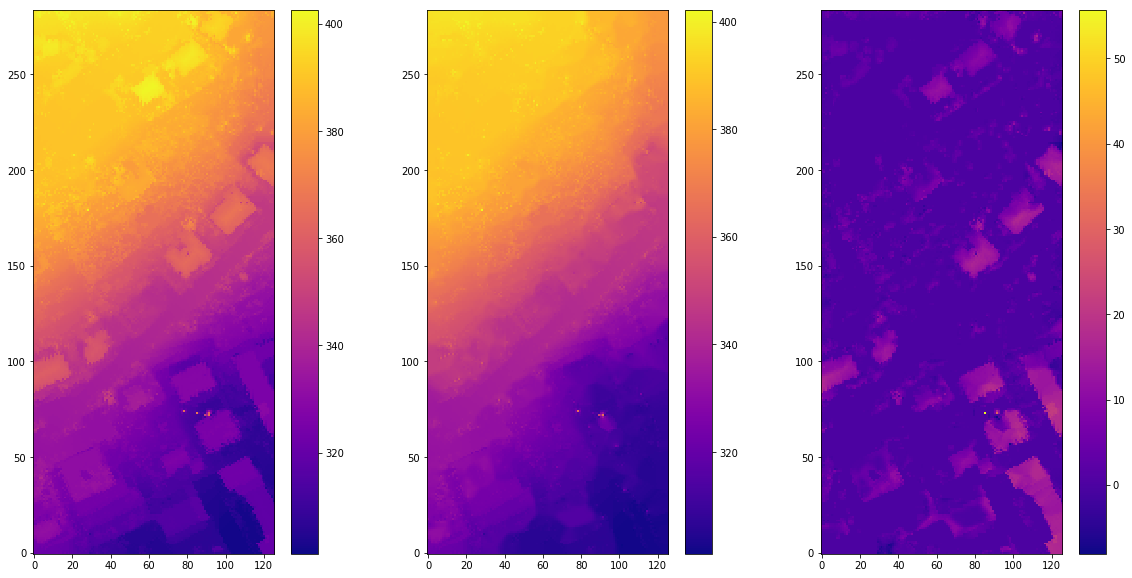

In [32]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(G, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-G, origin='lower'); plt.colorbar();

In [33]:
%%time
struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 1).astype(int)
gradDTM = morphology.grey_dilation(G, structure=struct)

CPU times: user 0 ns, sys: 10 ms, total: 10 ms
Wall time: 1.22 ms


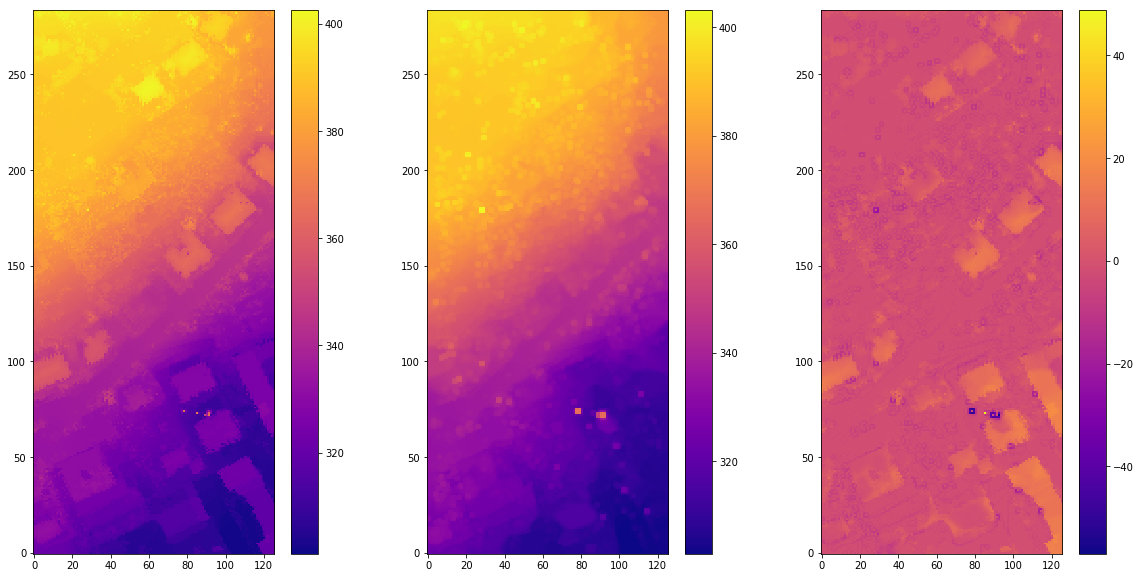

In [34]:
plt.figure(figsize=(20,10));
plt.subplot(1,3,1); plt.imshow(cz, origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(gradDTM, origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(cz-(gradDTM+b), origin='lower'); plt.colorbar();

In [35]:
%%time
xbins = np.digitize(df3D.X, xi)
ybins = np.digitize(df3D.Y, yi)
nonground = np.where(df3D.Z >= gradDTM[ybins-1, xbins-1]+b)
ground = np.where(df3D.Z < gradDTM[ybins-1, xbins-1]+b)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 8.24 ms


In [36]:
print "Detected", len(ground[0]), "ground and", len(nonground[0]), "non-ground points"

Detected 28720 ground and 9290 non-ground points


In [37]:
%%time
g = df3D.iloc[ground]
ng = df3D.iloc[nonground]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.38 ms


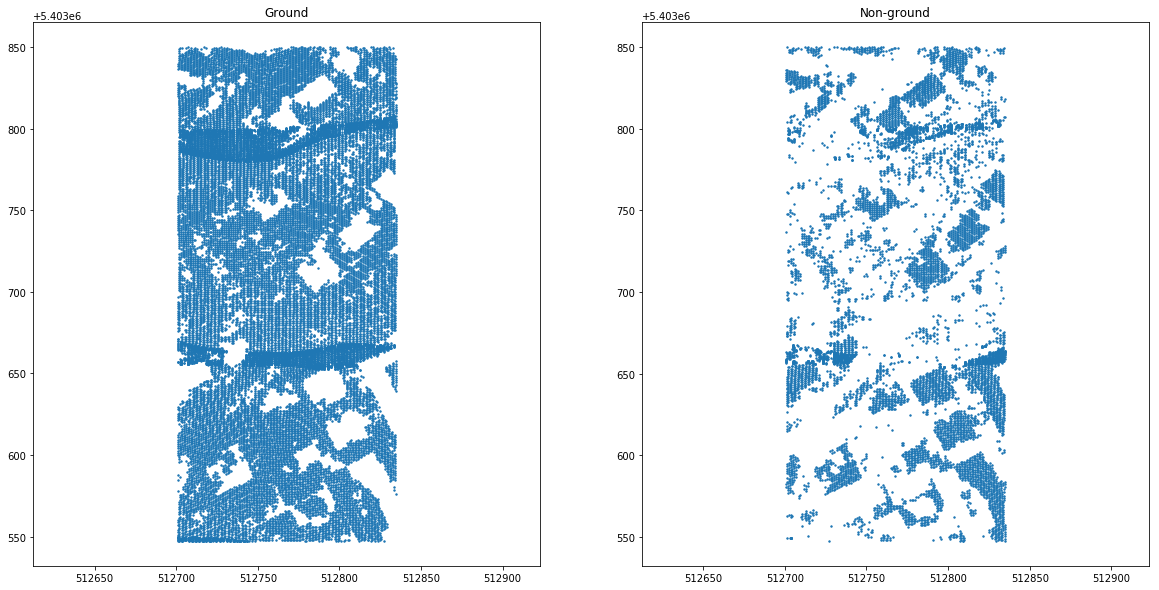

In [38]:
plt.figure(figsize=(20,10));
plt.subplot(1,2,1); plt.scatter(g.X, g.Y, s=2); plt.title('Ground'); plt.axis('equal');
plt.subplot(1,2,2); plt.scatter(ng.X, ng.Y, s=2); plt.title('Non-ground'); plt.axis('equal');

In [ ]:
json=u'''{
    "pipeline":[
        "/data/bare_earth_eval/isprs/converted/laz/samp11-utm.laz",
        {
            "type":"filters.python",
            "module":"anything",
            "function":"filter",
            "source":"from scipy import ndimage, signal, spatial
from scipy.ndimage import morphology

import numpy as np
import pandas as pd

S = 30
k = 0.2
n = 0.3
b = 0.2

def idw(data):
    # Find indices of the ground returns, i.e., anything that is not a nan, and create a KD-tree.
    # We will search this tree when looking for nearest neighbors to perform the interpolation.
    valid = np.argwhere(~np.isnan(data))
    tree = spatial.cKDTree(valid)
    
    # Now find indices of the non-ground returns, as indicated by nan values. We will interpolate
    # at these locations.
    nans = np.argwhere(np.isnan(data))    
    for row in nans:
        d, idx = tree.query(row, k=12)
        d = np.power(d, -2)
        v = data[valid[idx, 0], valid[idx, 1]]
        data[row[0], row[1]] = np.inner(v, d)/np.sum(d)
        
    return data

def filter(ins, outs):
    # Use the X, Y, and Z dimension data to classify points as ground or
    # non-ground.
    X = ins['X']
    Y = ins['Y']
    Z = ins['Z']

    # Begin by getting the Classification dimension and setting all values to 1
    # for unclassified.
    cls = ins['Classification']
    cls.fill(1)
    
    df3D = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})
    density = len(X) / (Y.ptp() * X.ptp())
    hres = 1. / density
    
    # Initilize the process by selecting points with lowest elevation at the target resolution.
    # Replace those points that are more than 1.0m below the estimated surface (as determined by
    # morphological opening/closing.

    # Next, we compute bin edges ranging between XY min and max, spaced at a fixed resolution.
    xi = np.ogrid[X.min():X.max():hres]
    yi = np.ogrid[Y.min():Y.max():hres]

    # We can effectively group all incoming points by their XY bin.
    bins = df3D.groupby([np.digitize(X, xi), np.digitize(Y, yi)])

    # Record coords of point with minimum Z for each XY bin.
    cz = np.empty((yi.size, xi.size))
    cz.fill(np.nan)
    czfoo = bins.Z.min()
    for name, val in czfoo.iteritems():
        cz[name[1]-1, name[0]-1] = val

    # For any remaining undefined cells, estimate via IDW
    cz = idw(cz)

    # Open the control elevations using a diamond structuring element with radius 11.
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 11).astype(int)
    opened = morphology.grey_opening(cz, structure=struct)

    # Close the control elevations using a diamond structuring element with radius 9.
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 9).astype(int)
    closed = morphology.grey_closing(opened, structure=struct)

    # Record the locations where there appear to be low outliers.
    lowx, lowy = np.where((closed - cz) >= 1.0)

    # Replace low outliers with the morphologically altered surface.
    cz[lowx, lowy] = closed[lowx, lowy]
    stdev = 14
    G = np.outer(signal.gaussian(113,stdev), signal.gaussian(113,stdev))
    low = signal.fftconvolve(np.pad(cz,2*stdev,'edge'), G, mode='same')[2*stdev:-2*stdev,2*stdev:-2*stdev]/1000.
    high = cz - low
    
    # Multiscale decomposition achieved by using a granulometry of morphological openings.
    erosions = []
    granulometry = []
    erosions.append(morphology.grey_erosion(high, size=3))
    for scale in xrange(1, S):
        erosions.append(morphology.grey_erosion(erosions[scale-1], size=3))
    for scale in xrange(1, S+1):
        granulometry.append(morphology.grey_dilation(erosions[scale-1], size=2*scale+1))
    
    # A top-hat scale-space, known as DMPs
    out = []
    for i in xrange(1, len(granulometry)):
        out.append(granulometry[i-1]-granulometry[i])
    
    # gprime registers the largest responses from the DMP
    # gstar describes the smallest scales at which the largest response is registered
    # gplus is the sum of all responses registered before and including the largest response
    xs, ys = out[0].shape
    gprime = np.maximum.reduce(out)
    gstar = np.zeros((xs,ys))
    gplus = np.zeros((xs,ys))
    for ii in xrange(0,xs):
        for jj in xrange(0,ys):
            for kk in xrange(0,len(out)):
                if out[kk][ii,jj] < gprime[ii,jj]:
                    gplus[ii,jj] += out[kk][ii,jj]
                if out[kk][ii,jj] == gprime[ii,jj]:
                    gplus[ii,jj] += out[kk][ii,jj]
                    gstar[ii,jj] = kk
                    break
    
    T = k * gstar + n
    Sg = gprime < T
    F=cz.copy()
    F[np.where(Sg==0)] = np.nan
    G=idw(F)
    struct = ndimage.iterate_structure(ndimage.generate_binary_structure(2, 1), 1).astype(int)
    gradDTM = morphology.grey_dilation(G, structure=struct)
    xbins = np.digitize(df3D.X, xi)
    ybins = np.digitize(df3D.Y, yi)
    ground = np.where(df3D.Z < gradDTM[ybins-1, xbins-1]+b)

    cls[ground] = 2

    # Set the output dimension and return.
    outs['Classification'] = cls
    return True"
        },
        "/data/bare_earth_eval/isprs/converted/laz/samp11-utm-dmp.las"
    ]
}'''
p = pdal.Pipeline(json)
p.validate()
p.execute()